# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.

**Описание данных**

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from numpy.random import RandomState
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor 
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

import time
import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В столбце о стоимости автомобиля минимальное значение 0, удалим и посмотрим аномалии. <br>
Странными выглядят данные о годе регистрации автомобиля. <br>
Данные о месяце регистрации автомобиля, количестве фотографий и почтовый индекс не являются информативными.

**Дубликаты**

In [6]:
data.duplicated().sum() #посмотрим явные дубликаты и удалим их

4

In [7]:
data.drop_duplicates(inplace=True)

**Пропуски**

In [8]:
data.isna().mean().round(2) #пропуски в процентном соотношении

DateCrawled          0.00
Price                0.00
VehicleType          0.11
RegistrationYear     0.00
Gearbox              0.06
Power                0.00
Model                0.06
Kilometer            0.00
RegistrationMonth    0.00
FuelType             0.09
Brand                0.00
Repaired             0.20
DateCreated          0.00
NumberOfPictures     0.00
PostalCode           0.00
LastSeen             0.00
dtype: float64

Отсутствующие данные:

- 11% тип автомобильного кузова
- 6% тип коробки передач
- 6% модель автомобиля
- 9% тип топлива
- 20% была ли машина в ремонте 

Заполним их новым значением "unknown"

Эти данные не содержат информацию о технических характеристиках и комплектации, которые могли бы влиять на стоимость автомобиля:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Удалим их

In [9]:
data = data.drop(columns = ['DateCrawled','RegistrationMonth','DateCreated','PostalCode','LastSeen','NumberOfPictures'])

In [10]:
data.rename(columns=str. lower, inplace=True) #приведем к нижнему регистру названия столбцов

In [11]:
data.rename(columns = {'vehicletype':'vehicle_type', 'registrationyear':'registration_year',
                       'fueltype':'fuel_type'}, inplace = True) 
#переименуем отдельные столбцы

In [12]:
data.tail() #посмотрим изменения

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no
354368,3400,wagon,2002,manual,100,golf,150000,gasoline,volkswagen,NaN


Заполним пропуски на "unknown"

In [13]:
for column in ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']:
    data[column] = data[column].fillna('unknown')

In [14]:
data.isna().sum() #проверим

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

---

**Просмотр признаков**

<u>*Цена*</u>

In [15]:
data.price.value_counts() #посмотрим объявления по стоимости автомобиля

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

In [16]:
data = data.query('price >100') #удалим те, которые менее 100 евро

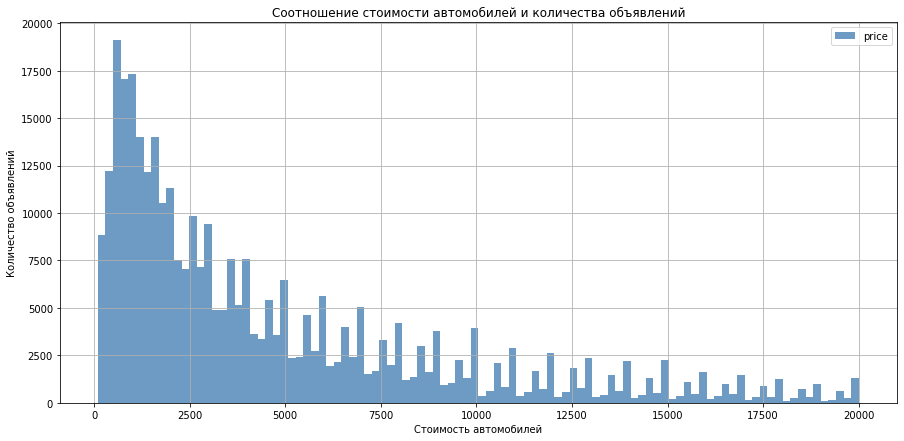

In [17]:
data.plot(kind='hist',y='price',grid=True, bins=100, figsize=(15,7), color='#6d9bc3', \
          title='Соотношение стоимости автомобилей и количества объявлений')
plt.xlabel('Стоимость автомобилей')
plt.ylabel('Количество объявлений')
plt.show()

<u>*Тип автомобильного кузова*</u>

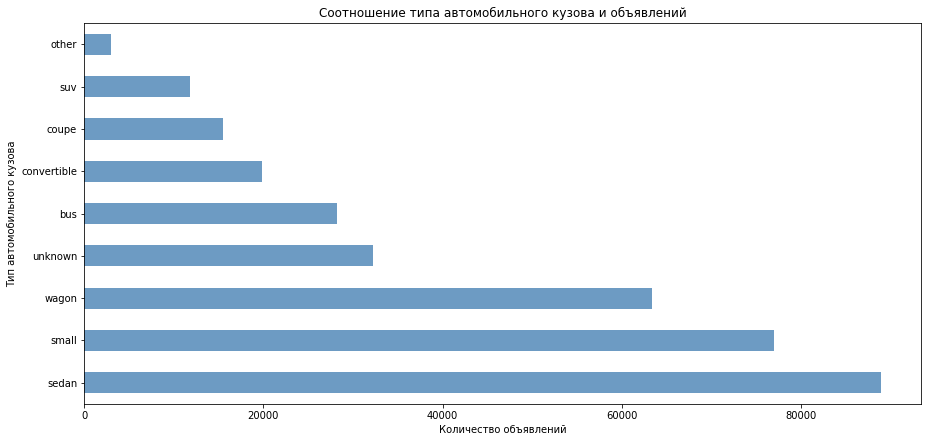

In [18]:
data['vehicle_type'].value_counts().plot.barh(figsize=(15,7), color='#6d9bc3', title = 'Соотношение типа автомобильного кузова и объявлений')
plt.ylabel('Тип автомобильного кузова')
plt.xlabel('Количество объявлений')
plt.show() #построим столбчатую диаграмму

In [19]:
data['vehicle_type'] = data['vehicle_type'].replace('other','unknown') #объединим категории в одну

<u>*Год регистрации автомобиля*</u>

In [20]:
data['registration_year'].value_counts().sort_values(ascending=False)

2000    22496
1999    21779
2005    21341
2006    19639
2001    19549
        ...  
9450        1
1001        1
5600        1
3800        1
2290        1
Name: registration_year, Length: 136, dtype: int64

Удалим объявления раньше 1960 и позднее 2016 года (при просмотре первых строк в столбце с датой создания анкеты)

In [21]:
data = data.query('1960 <= registration_year <= 2016') #удалим их

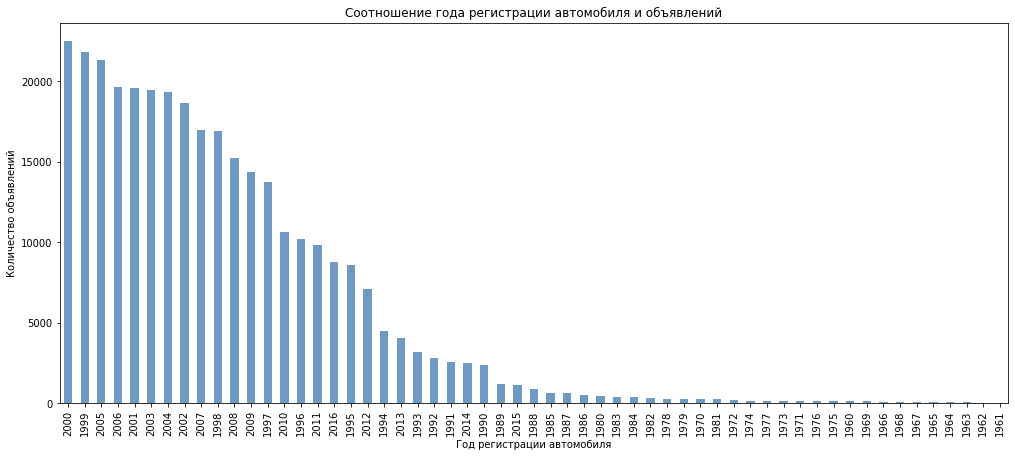

In [22]:
data['registration_year'].value_counts().plot.bar(figsize=(17,7), color='#6d9bc3', title = 'Соотношение года регистрации автомобиля и объявлений')
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Количество объявлений')
plt.show() #построим столбчатую диаграмму

Категоризируем автомобили по их году регистрации

In [23]:
def categorize_year(year):
    try:
        if 1960 <= year <= 1980:
            return 'super_retro'
        elif 1981 <= year <= 2000:
            return 'retro'
        elif 2001 <= year <= 2011:
            return 'old'
        elif year >= 2012:
            return 'new'
    except:
        pass

In [24]:
data['category_year'] = data['registration_year'].apply(categorize_year) #перезапишем в новый столбец


In [25]:
data = data.drop(columns = ['registration_year']) #удалим столбец с годом регистрации

In [26]:
data.head()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,category_year
0,480,unknown,manual,0,golf,150000,petrol,volkswagen,unknown,retro
1,18300,coupe,manual,190,unknown,125000,gasoline,audi,yes,old
2,9800,suv,auto,163,grand,125000,gasoline,jeep,unknown,old
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,old
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,old


<u>*Тип коробки передач*</u>

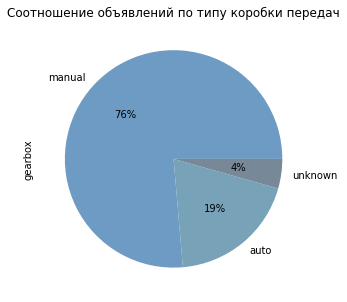

In [27]:
data['gearbox'].value_counts().plot(
    kind = 'pie',
    y = data, 
    autopct='%1.0f%%',
    figsize=(5,5),
    colors= ['#6d9bc3', '#78a2b7', '#778899'],
    title = 'Соотношение объявлений по типу коробки передач');

<u>*Мощность*<u/>

In [28]:
data['power'].value_counts()

0       31100
75      21916
60      14553
150     13686
101     12373
        ...  
1082        1
6045        1
671         1
1339        1
1653        1
Name: power, Length: 680, dtype: int64

В 2016 году максимальная мощность 1500 лошадиных сил у Bugatti Chiron [по ссылке](https://www.dk.ru/news/10-samyh-moschnyh-i-bystryh-avtomobiley-2016-goda-237064202), поэтому лимит до 1500 л.с.

In [29]:
data = data.query('0 <= power <= 1500') #оставим машины с 0-ой мощностью, они могут быть просто без двигателя
data['power'].describe()

count    325880.000000
mean        109.657834
std          65.572187
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max        1500.000000
Name: power, dtype: float64

<u>*Пробег*<u/>

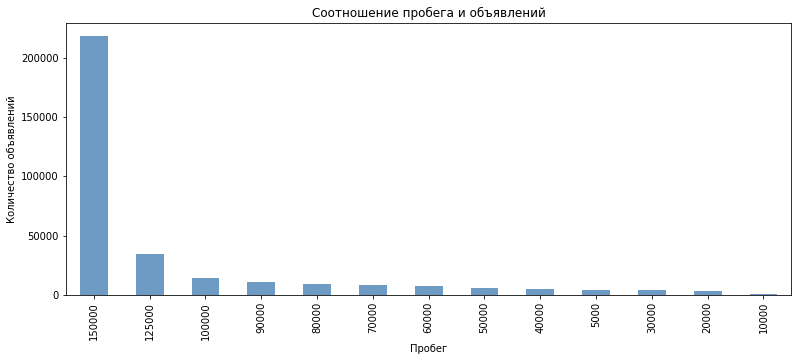

In [30]:
data['kilometer'].value_counts().plot.bar(figsize=(13,5), color='#6d9bc3', title = 'Соотношение пробега и объявлений')
plt.xlabel('Пробег')
plt.ylabel('Количество объявлений')
plt.show() #построим столбчатую диаграмму

<u>*Тип топлива*<u/>

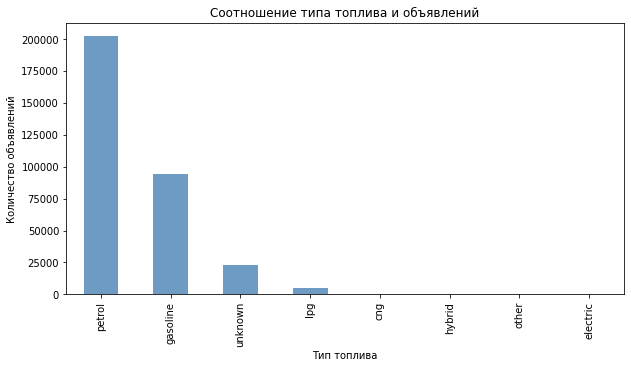

In [31]:
data['fuel_type'].value_counts().plot.bar(figsize=(10,5), color='#6d9bc3', title = 'Соотношение типа топлива и объявлений')
plt.xlabel('Тип топлива')
plt.ylabel('Количество объявлений')
plt.show() #построим столбчатую диаграмму

In [32]:
data['fuel_type'] = data['fuel_type'].replace('other','unknown') #объединим категории в одну

Объединим в одну категорию, бензин называют petrol в Великобритании и gasoline в США

In [33]:
data['fuel_type'] = data['fuel_type'].replace('petrol','gasoline') #объединим категории в одну

<u>*Марка автомобиля*<u/>

In [34]:
data['brand'].sort_values(ascending = True).unique() #посмотрим уникальные значения

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

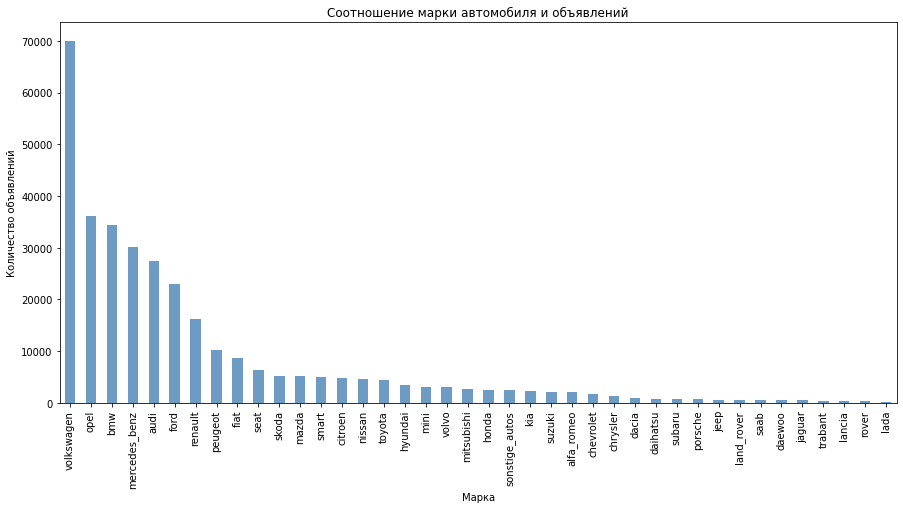

In [35]:
data['brand'].value_counts().plot.bar(figsize=(15,7), color='#6d9bc3', title = 'Соотношение марки автомобиля и объявлений')
plt.xlabel('Марка')
plt.ylabel('Количество объявлений')
plt.show() #построим столбчатую диаграмму

<u>*Ремонт*<u/>

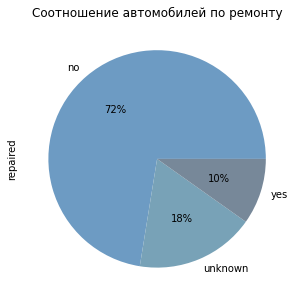

In [36]:
data['repaired'].value_counts().plot(
    kind = 'pie',
    y = data, 
    autopct='%1.0f%%',
    figsize=(5,5),
    colors= ['#6d9bc3', '#78a2b7', '#778899'],
    title = 'Соотношение автомобилей по ремонту');

In [37]:
data = data.reset_index(drop=True)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325880 entries, 0 to 325879
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   price          325880 non-null  int64 
 1   vehicle_type   325880 non-null  object
 2   gearbox        325880 non-null  object
 3   power          325880 non-null  int64 
 4   model          325880 non-null  object
 5   kilometer      325880 non-null  int64 
 6   fuel_type      325880 non-null  object
 7   brand          325880 non-null  object
 8   repaired       325880 non-null  object
 9   category_year  325880 non-null  object
dtypes: int64(3), object(7)
memory usage: 24.9+ MB


<div style="border:solid steelblue 2px; padding: 10px; border-radius: 5px">
    Удалили дубликаты, пропуски заполнили “unknown”, неинформативные столбцы.  <br>  
    Привели к нижнему регистру и переименовали столбцы, объединили и категоризировали некоторые значения.
    <br>
    
Чаще всего продают автомобили со следующими параметрами: седан, год регистрации около 2000 года, механическая коробка передач, пробег около 150000 км, бензиновый двигатель, марка Volkswagen, автомобиль был в ремонте.

## Обучение моделей

### Подготовка выборок

In [39]:
features = data.drop(columns=['price'])
target = data['price'] #признаки и целевой признак

In [40]:
state = np.random.RandomState(12345) #зафиксируем random_state

Разобъем данные на обучающую,валидацонную и тестовую выборки

In [41]:
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                            target,
                                                                            test_size = 0.4,
                                                                            random_state=state)

In [42]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size = 0.5,
                                                                            random_state=state)

In [43]:
features_train.shape, features_valid.shape, features_test.shape #посмотрим размеры выборок

((195528, 9), (65176, 9), (65176, 9))

Закодируем категориальные признаки и масштабируем численные

In [44]:
cat = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand','repaired', 'category_year'] 

In [45]:
num = ['power', 'kilometer']

In [46]:
ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(features_train[cat])

def features_ohe(ohe_variable, data_features, cat):
    data_features_ohe = pd.DataFrame(data=ohe_variable.transform(data_features[cat]),
                                     index=data_features.index, columns=ohe_variable.get_feature_names())

    data_features = data_features.drop(cat, axis=1)
    data_features = data_features.join(data_features_ohe)
    return data_features    

features_train_ohe = features_ohe(ohe, features_train, cat)
features_valid_ohe = features_ohe(ohe, features_valid, cat)
features_test_ohe = features_ohe(ohe, features_test, cat)

In [47]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[num])

StandardScaler()

In [48]:
features_train_ohe[num] = scaler.transform(features_train_ohe[num])
features_valid_ohe[num] = scaler.transform(features_valid_ohe[num])
features_test_ohe[num] = scaler.transform(features_test_ohe[num])

In [49]:
features_train_ohe.shape, features_valid_ohe.shape, features_test_ohe.shape #посмотрим размеры преобразованных выборок

((195528, 310), (65176, 310), (65176, 310))

Напишем функции для времени обучения и предсказания, RMSE

In [50]:
def learning_time(model,features_train,target_train):
    start = time.time()
    model.fit(features_train,target_train)
    end = time.time()
    time_fit = end - start
    return time_fit,model #время обучения

In [51]:
def predicted_time(model,features_valid):
    start = time.time()
    predict = model.predict(features_valid)
    end = time.time()
    time_predict= end - start
    return time_predict,predict #время предсказания

In [52]:
results = pd.DataFrame(columns=['Время обучения', 'Время предсказания', 'RMSE', 'Модель']) #результаты работы моделей

In [53]:
def table_results(learn_time, pred_time, rmse, model, df):
    df.loc[model,'Время обучения'] = learn_time
    df.loc[model,'Время предсказания'] = pred_time
    df.loc[model,'RMSE'] = rmse
    df.loc[model,'Модель'] = model
    return df

In [54]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(9, 5))
    plt.title('Важность факторов при моделировании')
    plt.barh(range(len(indices)), importances[indices], color='#6d9bc3', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Результативная метрика']
    display(feat_importances) #важность признаков и их показатели при моделировании

### Модели

Обучим разные модели, попробуем разные гиперпараметры

**LightGBM Regressor**

*LightGBM - 1*

In [55]:
lgbm1_learn_time,lgbm1 = learning_time(LGBMRegressor(learning_rate=0.1, num_leaves=170, 
                                                     n_estimators=80,random_state=state),
                                       features_train_ohe, target_train)
lgbm1_pred_time,lgbm1_predict = predicted_time(lgbm1,features_valid_ohe)
lgbm1_rmse = np.sqrt(mean_squared_error(target_valid, lgbm1_predict))
table_results(lgbm1_learn_time,lgbm1_pred_time, lgbm1_rmse, 'LightGBM - 1',results)

,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,849.082229,1.203863,2015.04945,LightGBM - 1


*LightGBM - 2*

In [56]:
lgbm2_learn_time,lgbm2 = learning_time(LGBMRegressor(learning_rate=0.01, num_leaves=190, 
                                                     n_estimators=150,random_state=state),
                                       features_train_ohe, target_train)
lgbm2_pred_time,lgbm2_predict = predicted_time(lgbm2,features_valid_ohe)
lgbm2_rmse = np.sqrt(mean_squared_error(target_valid, lgbm2_predict))
table_results(lgbm2_learn_time,lgbm2_pred_time, lgbm2_rmse, 'LightGBM - 2',results)

,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,849.082229,1.203863,2015.04945,LightGBM - 1
LightGBM - 2,79.078567,1.396188,2468.954249,LightGBM - 2


----

**Random Forest Regressor**

*Random Forest - 1*

In [57]:
rf1_learn_time,rf1 = learning_time(RandomForestRegressor(n_estimators=13, max_depth=15, random_state=state),
                                   features_train_ohe, target_train)
rf1_pred_time,rf1_predict = predicted_time(rf1,features_valid_ohe)
rf1_rmse = np.sqrt(mean_squared_error(target_valid, rf1_predict))
table_results(rf1_learn_time,rf1_pred_time, rf1_rmse, 'RandomForest - 1',results)

,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,849.082229,1.203863,2015.04945,LightGBM - 1
LightGBM - 2,79.078567,1.396188,2468.954249,LightGBM - 2
RandomForest - 1,34.968417,0.290715,2179.676296,RandomForest - 1


*Random Forest - 2*

In [58]:
rf2_learn_time,rf2 = learning_time(RandomForestRegressor(n_estimators=25, max_depth=19, random_state=state),
                                   features_train_ohe, target_train)
rf2_pred_time,rf2_predict = predicted_time(rf2,features_valid_ohe)
rf2_rmse = np.sqrt(mean_squared_error(target_valid, rf2_predict))
table_results(rf2_learn_time,rf2_pred_time, rf2_rmse, 'RandomForest - 2',results)

,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,849.082229,1.203863,2015.04945,LightGBM - 1
LightGBM - 2,79.078567,1.396188,2468.954249,LightGBM - 2
RandomForest - 1,34.968417,0.290715,2179.676296,RandomForest - 1
RandomForest - 2,73.560909,0.378474,2079.107728,RandomForest - 2


----

**CatBoostRegressor**

*CatBoostRegressor - 1*

In [59]:
cat1_learn_time,cat1 = learning_time(CatBoostRegressor(loss_function = 'RMSE', learning_rate=0.01, 
                                                       iterations = 270, cat_features = cat, verbose=20), 
                                     features_train, target_train)
cat1_pred_time,cat1_predict = predicted_time(cat1,features_valid)
cat1_rmse = np.sqrt(mean_squared_error(target_valid, cat1_predict))
table_results(cat1_learn_time,cat1_pred_time, cat1_rmse, 'CatBoost - 1',results)

0:	learn: 4512.0654133	total: 340ms	remaining: 1m 31s
20:	learn: 4043.7174536	total: 4.41s	remaining: 52.2s
40:	learn: 3673.9257630	total: 8.35s	remaining: 46.6s
60:	learn: 3390.9109801	total: 12.4s	remaining: 42.5s
80:	learn: 3174.6887169	total: 16.5s	remaining: 38.4s
100:	learn: 3003.6285466	total: 20.6s	remaining: 34.4s
120:	learn: 2865.1156885	total: 24.7s	remaining: 30.4s
140:	learn: 2758.9132785	total: 28.6s	remaining: 26.1s
160:	learn: 2678.1142103	total: 32.7s	remaining: 22.2s
180:	learn: 2616.5735844	total: 36.4s	remaining: 17.9s
200:	learn: 2568.7032011	total: 40.2s	remaining: 13.8s
220:	learn: 2531.6989055	total: 43.7s	remaining: 9.68s
240:	learn: 2501.8917218	total: 47.4s	remaining: 5.7s
260:	learn: 2478.9608168	total: 51s	remaining: 1.76s
269:	learn: 2469.4668702	total: 52.7s	remaining: 0us


,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,849.082229,1.203863,2015.04945,LightGBM - 1
LightGBM - 2,79.078567,1.396188,2468.954249,LightGBM - 2
RandomForest - 1,34.968417,0.290715,2179.676296,RandomForest - 1
RandomForest - 2,73.560909,0.378474,2079.107728,RandomForest - 2
CatBoost - 1,54.169193,0.140352,2485.096398,CatBoost - 1


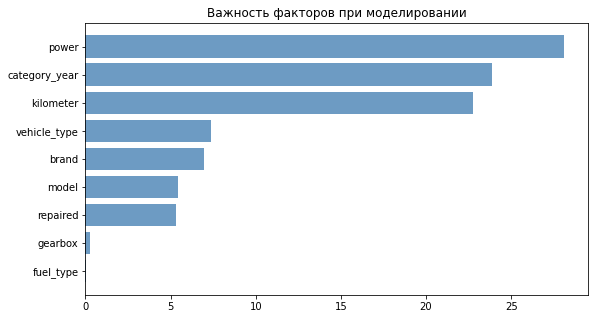

,Результативная метрика
power,28.089802
category_year,23.850114
kilometer,22.756968
vehicle_type,7.366308
brand,6.940083
model,5.409361
repaired,5.337793
gearbox,0.241807
fuel_type,0.007766


In [60]:
importances(cat1,features_train) #посмотрим важность признаков

*CatBoostRegressor - 2*

In [61]:
cat2_learn_time,cat2 = learning_time(CatBoostRegressor(loss_function = 'RMSE', learning_rate=0.1, 
                                                       iterations = 90, cat_features = cat, verbose=13), 
                                     features_train, target_train)
cat2_pred_time,cat2_predict = predicted_time(cat2,features_valid)
cat2_rmse = np.sqrt(mean_squared_error(target_valid, cat1_predict))
table_results(cat2_learn_time,cat1_pred_time, cat2_rmse, 'CatBoost - 2',results)

0:	learn: 4282.0559113	total: 108ms	remaining: 9.6s
13:	learn: 2795.7568583	total: 1.09s	remaining: 5.9s
26:	learn: 2493.7956696	total: 2.04s	remaining: 4.76s
39:	learn: 2416.5167240	total: 3s	remaining: 3.75s
52:	learn: 2378.8386954	total: 3.96s	remaining: 2.76s
65:	learn: 2346.3726896	total: 4.9s	remaining: 1.78s
78:	learn: 2319.8843673	total: 5.88s	remaining: 818ms
89:	learn: 2303.9606395	total: 6.67s	remaining: 0us


,Время обучения,Время предсказания,RMSE,Модель
LightGBM - 1,849.082229,1.203863,2015.04945,LightGBM - 1
LightGBM - 2,79.078567,1.396188,2468.954249,LightGBM - 2
RandomForest - 1,34.968417,0.290715,2179.676296,RandomForest - 1
RandomForest - 2,73.560909,0.378474,2079.107728,RandomForest - 2
CatBoost - 1,54.169193,0.140352,2485.096398,CatBoost - 1
CatBoost - 2,7.435526,0.140352,2485.096398,CatBoost - 2


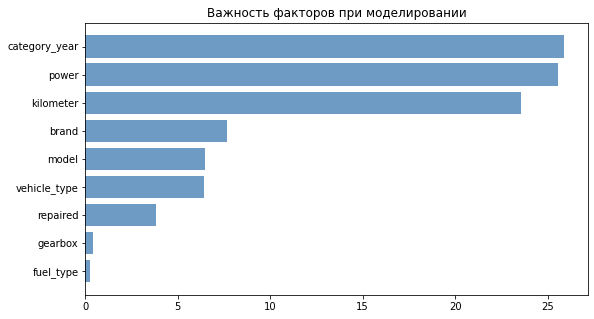

,Результативная метрика
category_year,25.874311
power,25.588630
kilometer,23.553863
brand,7.644725
model,6.483292
vehicle_type,6.411743
repaired,3.789717
gearbox,0.408593
fuel_type,0.245125


In [62]:
importances(cat2,features_train) #посмотрим важность признаков

## Анализ моделей

Все модели прошли критерий значения метрики RMSE меньше 2500.

Наилучший показатель RMSE 2015.05 у модели LightGBM-1, скорость средняя. Протестируем.


In [63]:
model_lgbm = LGBMRegressor(learning_rate=0.1, num_leaves=170, n_estimators=80,random_state=state)
model_lgbm.fit(features_train_ohe, target_train)
predicted_lgbm = model_lgbm.predict(features_test_ohe)
print('Значение RMSE модели LightGBM-1 на тестовой выборке:', np.sqrt(mean_squared_error(target_test, predicted_lgbm)))

Значение RMSE модели LightGBM-1 на тестовой выборке: 2007.8016165784031


## Вывод

<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
Сделали предобработку данных. Удалили дубликаты, пропуски заполнили “unknown”, неинформативные столбцы.
Привели к нижнему регистру и переименовали столбцы, объединили и категоризировали некоторые значения.<br>

    
Чаще всего продают автомобили со следующими параметрами: седан, год регистрации около 2000 года, механическая коробка передач, пробег около 150000 км, бензиновый двигатель, марка Volkswagen, автомобиль был в ремонте.<br>
<br>
    
Обучили модели с разными гиперпараметрами LightGBM Regressor, Random Forest Regressor и CatBoostRegressor.<br>
Все модели прошли критерий значения метрики RMSE меньше 2500.<br>

<br>    
Наилучший показатель RMSE 2015.05 у модели LightGBM-1,скорость обучения средняя.<br>
    
<br>
Значение RMSE модели LightGBM-1 на тестовой выборке: 2007.8.<br>
    Результат модели на тестовой выборке очень близок к полученному RMSE.